<a href="https://colab.research.google.com/github/Anjali98765/SheHacks/blob/main/Boxbrains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contamination is a huge problem in the recycling industry that can be mitigated with automated waste sorting. Here's a prototype of an image classifier to classify trash and recyclables - this classifier could have applications in an optical sorting system.

**Building an image classifier**

In this project, I'll train a convolutional neural network to classify an image as either cardboard, glass, metal, paper, plastic, or trash with the fastai library (built on PyTorch). I used an image dataset collected manually by Gary Thung and Mindy Yang.

Steps:-
    
1 Download and extract the images

2 Organize the images into different folders

3 Train the model

4 Male and evaluate test predictions


**STEP 1 :
Importing necessary libraries**
(Extracting the contents of "dataset-resized.zip")

In [45]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [46]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [47]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip "/content/gdrive/My Drive/SHEHACKS_BOXBRAINS_DUSTBIN2.0/dataset-resized.zip"


**Step 2 Organize images into different folders**

Now that we've extracted the data, We are going to split images up into train, validation, and test image folders with a 50-25-25 split. First, we'll define some functions that will help me quickly build it.


In [48]:
##Helper Function##
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [54]:
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

**Observation :** We set the seed for both random samples to be 1 for reproducibility. Now that the data's organized, we can get to model training.

In [55]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [56]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

**Observation :** The batch size bs is how many images you'll train at a time. We can choose a smaller batch size if computer has less memory.
get_transforms() function is used to augment the data

In [57]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [58]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


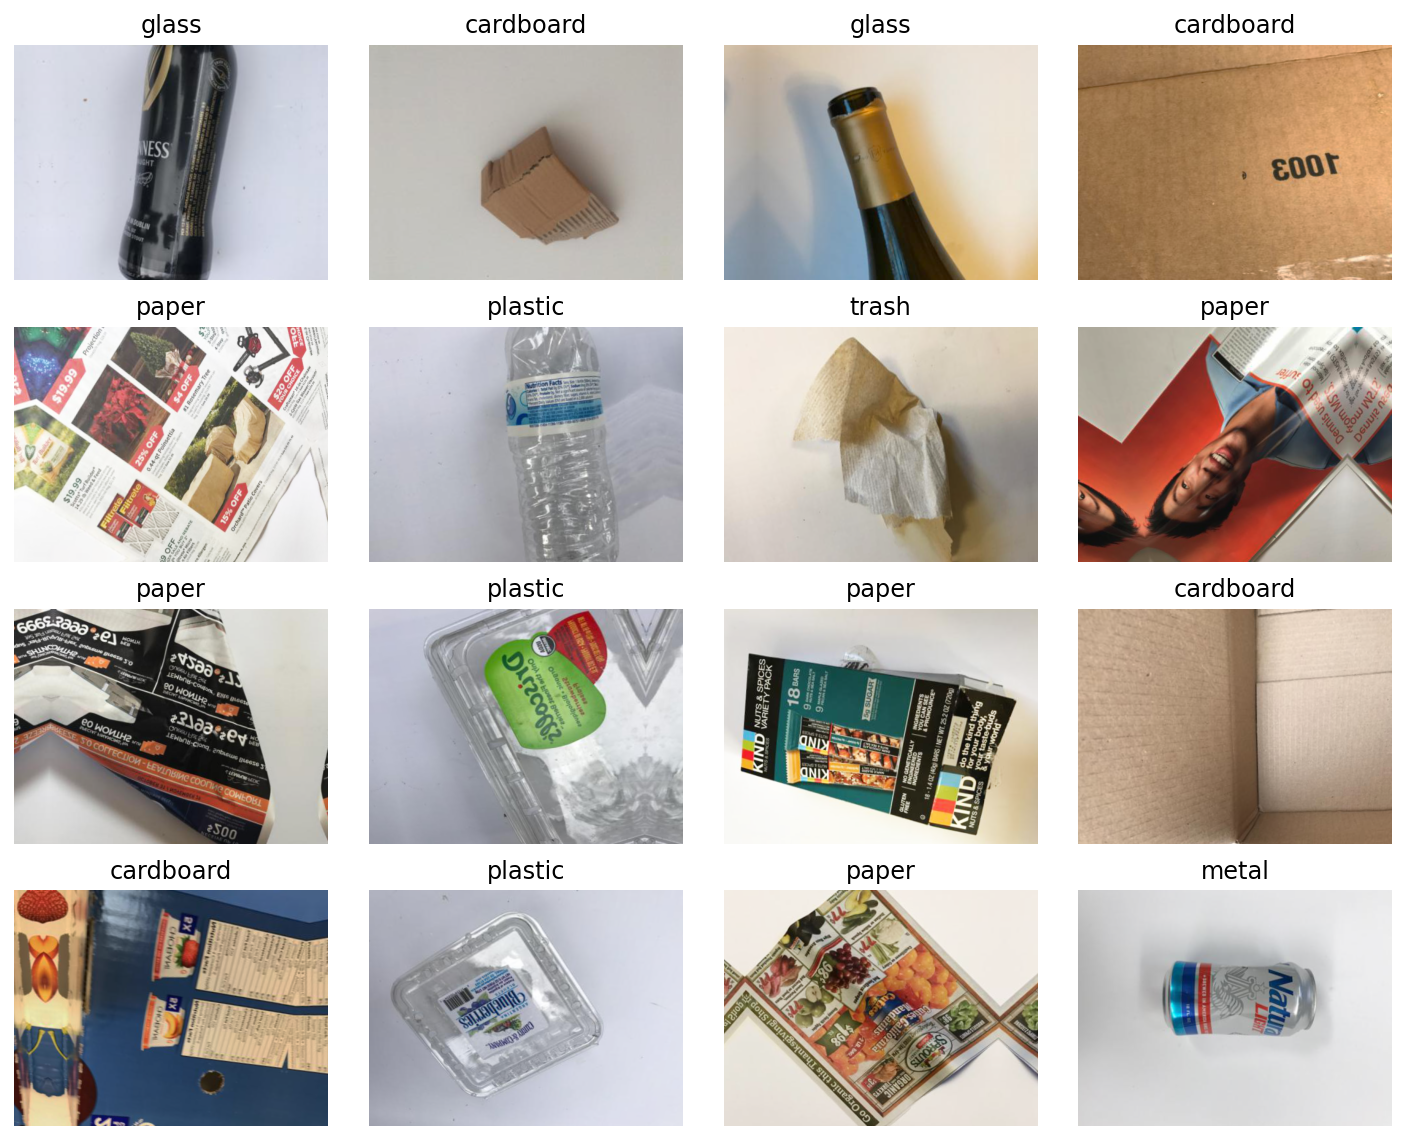

In [59]:
data.show_batch(rows=4,figsize=(10,8))

**Observation :** Here's an example how the data looks like.

**Step 3 Model training**

In [61]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

**Resnet34** : A residual neural network is a convolutional neural network (CNN) with lots of layers.
Resnets were created to circumvent this glitch using a hack called shortcut connections. If some nodes in a layer have suboptimal values, you can adjust weights and bias; if a node is optimal (its residual is 0), why not leave it alone? Adjustments are only made to nodes on an as-needed basis (when there's non-zero residuals).

In [62]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

**Step 3a : Finding a learning rate**

We are going to find a learning rate for gradient descent to make sure that our neural network converges reasonably quickly without missing the optimal error.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


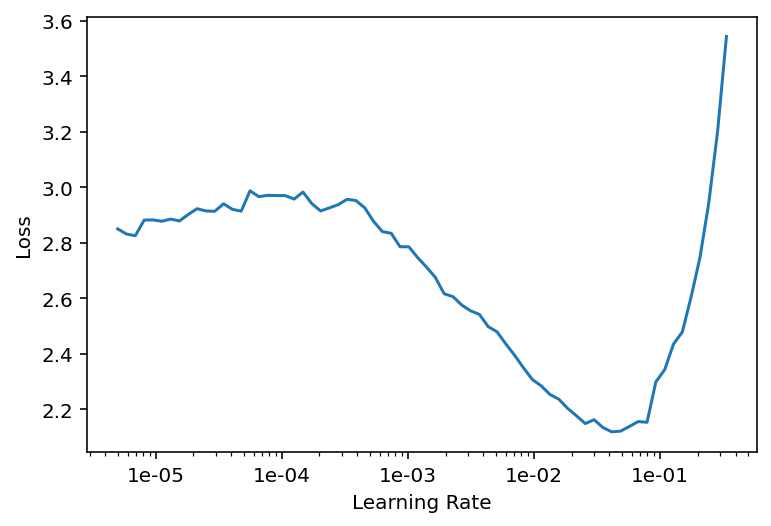

In [63]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

**Observation :**The learning rate finder suggests a learning rate of 1e-6. With this, we can train the model.

**Step 3b: Training**

In [64]:
learn.fit_one_cycle(2,max_lr=5.13e-03)

**Observation :** We ran our model for 2 epochs. In this fitting method the learning rate decreases with each epoch, allowing us to get closer and closer to the optimum. At 27.57%, the validation error looks super good.

**Step 3c: VIsualizing most incorrect images**

In [65]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

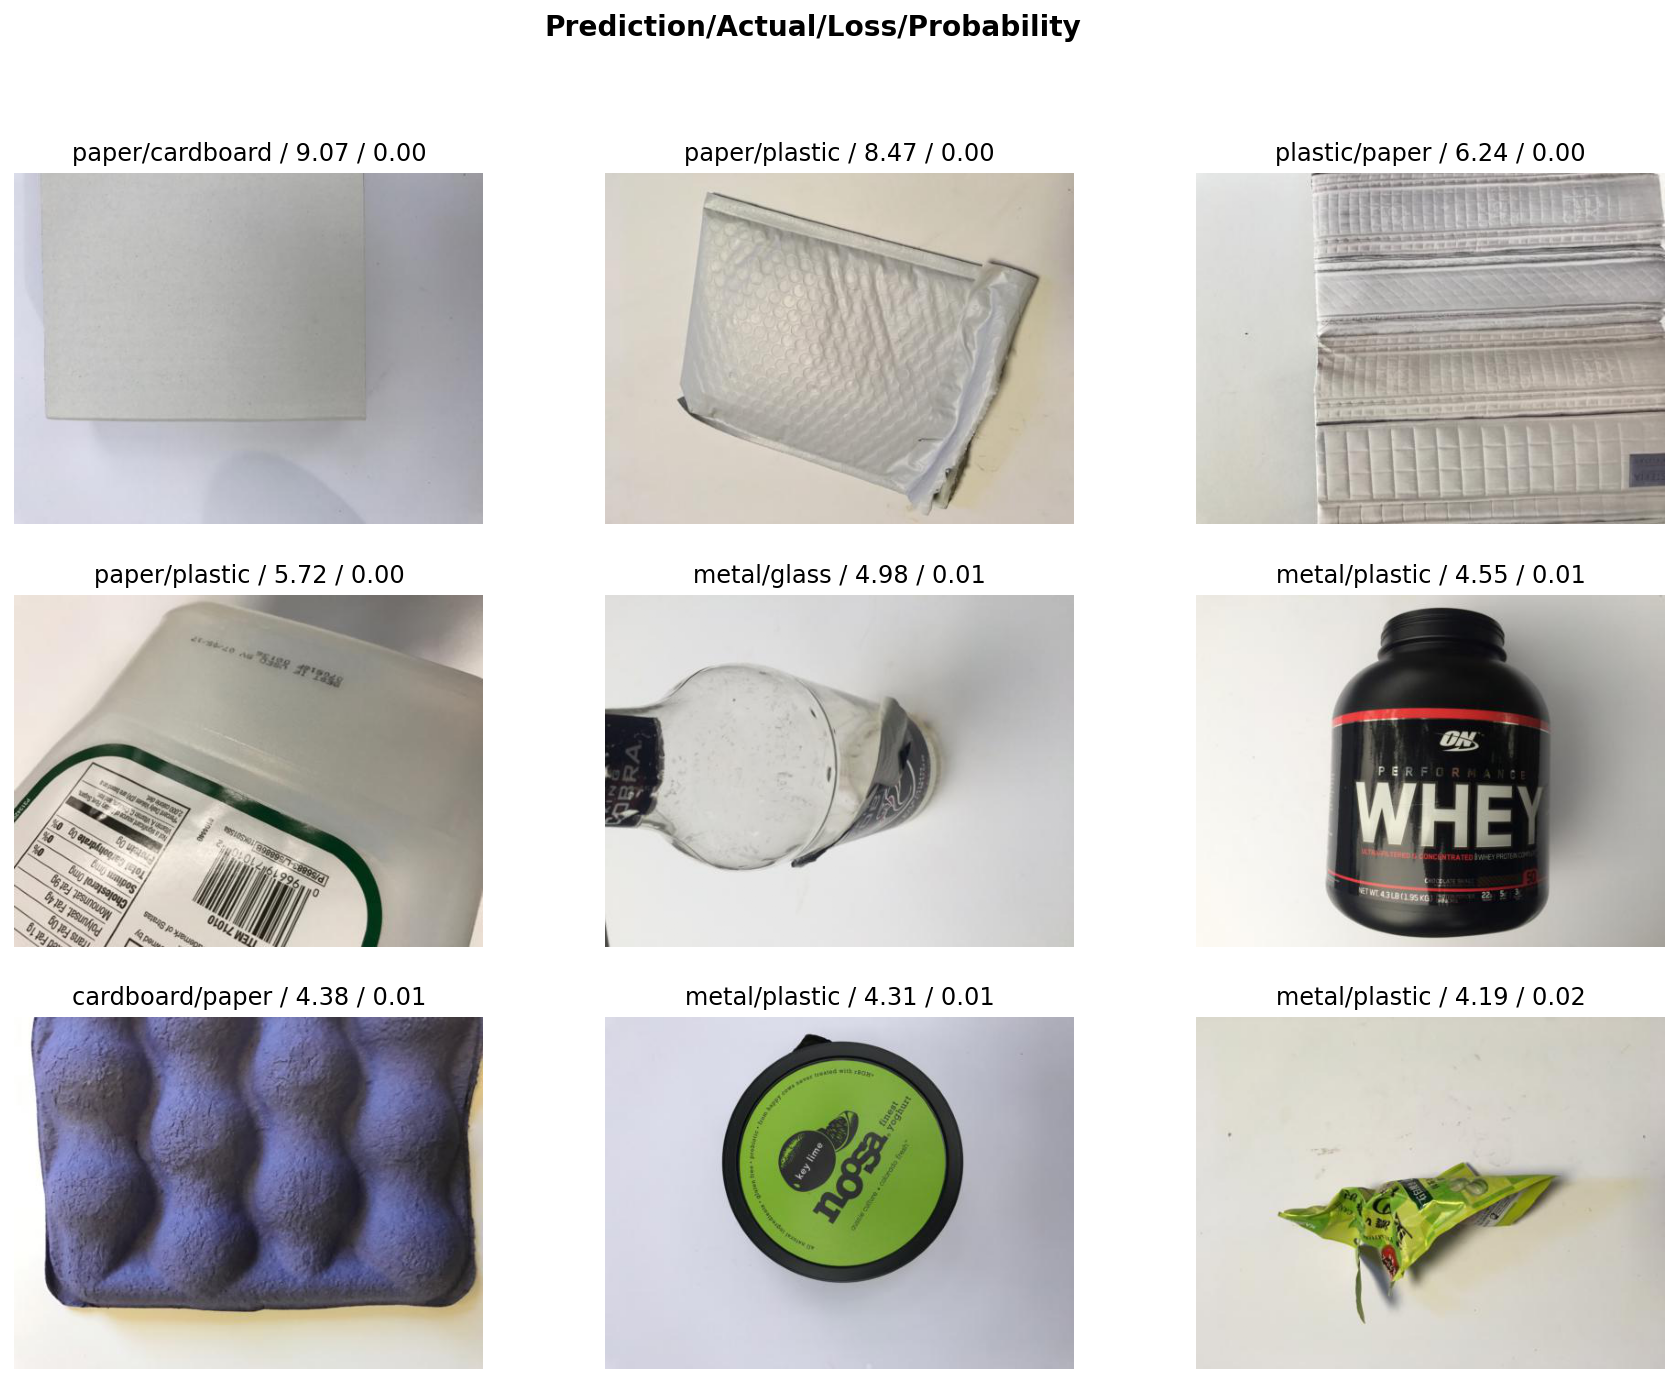

In [66]:
interp.plot_top_losses(9, figsize=(15,11))


**Observation :** The images here tells us that the recycler performed poorly on were actually degraded. It looks the photos received too much exposure or something so this actually isn't a fault with the model!

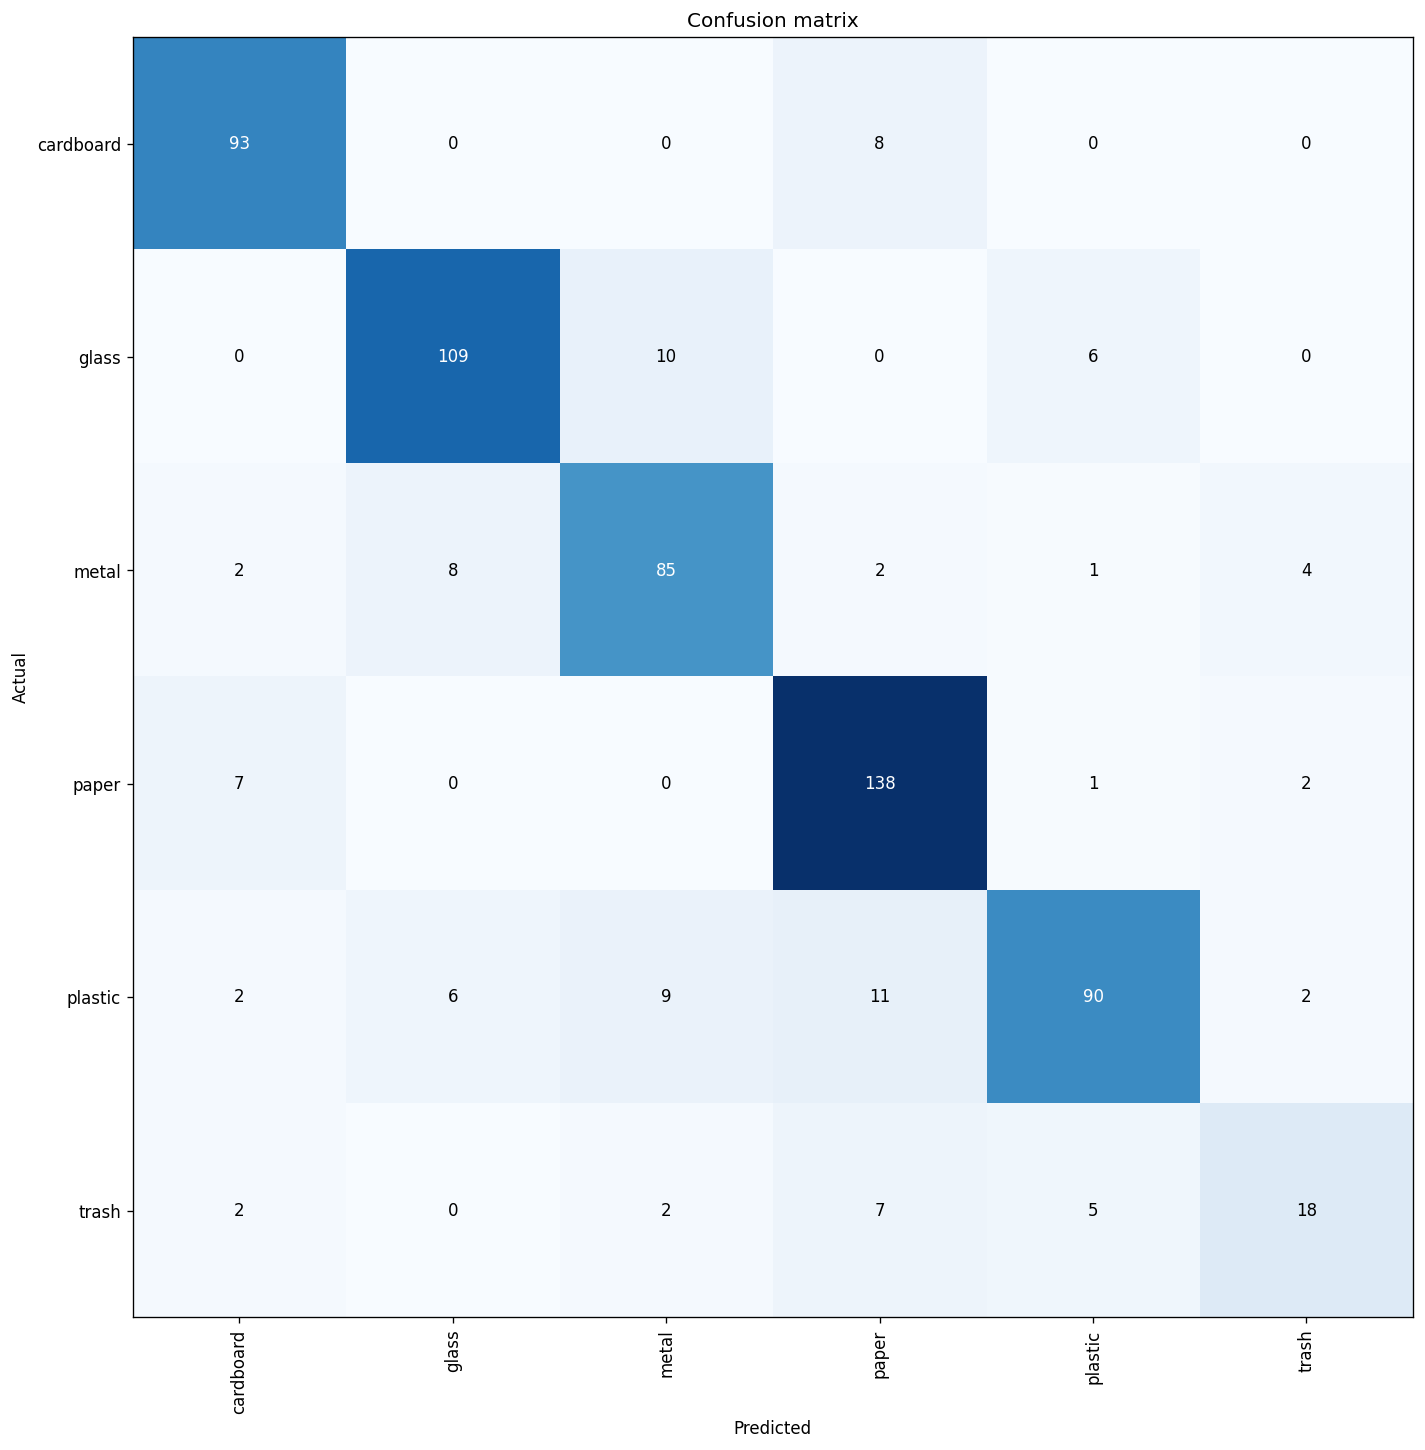

In [67]:
#Plotting confusion matrix
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

**Observation :** This model often confused plastic for glass and confused metal for glass. The list of most confused images is below.

In [68]:
interp.most_confused(min_val=2)

[('plastic', 'paper', 11),
 ('glass', 'metal', 10),
 ('plastic', 'metal', 9),
 ('cardboard', 'paper', 8),
 ('metal', 'glass', 8),
 ('paper', 'cardboard', 7),
 ('trash', 'paper', 7),
 ('glass', 'plastic', 6),
 ('plastic', 'glass', 6),
 ('trash', 'plastic', 5),
 ('metal', 'trash', 4),
 ('metal', 'cardboard', 2),
 ('metal', 'paper', 2),
 ('paper', 'trash', 2),
 ('plastic', 'cardboard', 2),
 ('plastic', 'trash', 2),
 ('trash', 'cardboard', 2),
 ('trash', 'metal', 2)]

**Step 4: Make new predictions on test data**

We need to make predictions on test data. First, we'll make predictions on the test data using the learner.get_preds() method.

learner.get_preds() predicts on a set of images.

In [71]:
preds = learn.get_preds(ds_type=DatasetType.Test)

KeyboardInterrupt: ignored

**Observation :** 

The ds_type argument in get_preds(ds_type) takes a DataSet argument.


In [70]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[4.5846e-01, 3.1249e-02, 1.5645e-02, 1.9869e-01, 2.8789e-01, 8.0745e-03],
        [3.4571e-04, 1.6447e-04, 5.2312e-05, 2.0745e-07, 9.9936e-01, 7.9230e-05],
        [1.0000e+00, 1.5162e-11, 1.3505e-10, 2.1921e-08, 7.8411e-14, 1.8534e-09],
        ...,
        [8.9544e-01, 5.6485e-04, 5.3593e-02, 6.5906e-03, 1.5162e-03, 4.2295e-02],
        [6.6568e-01, 1.8707e-03, 1.5195e-02, 2.0961e-01, 1.1323e-02, 9.6317e-02],
        [2.3973e-02, 2.4249e-01, 6.8453e-01, 1.2465e-02, 3.5994e-02, 5.4426e-04]])

**Observation :** These are the predicted probablities for each image. This tensor has 365 rows -- one for each image -- and 6 columns -- one for each material category.

In [72]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Going to convert the probabilities in the tensor above to a string with one of the class names.

In [73]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [74]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [75]:
yhat

['cardboard',
 'plastic',
 'cardboard',
 'paper',
 'paper',
 'metal',
 'metal',
 'glass',
 'cardboard',
 'paper',
 'paper',
 'cardboard',
 'glass',
 'glass',
 'plastic',
 'plastic',
 'plastic',
 'metal',
 'metal',
 'metal',
 'plastic',
 'paper',
 'metal',
 'cardboard',
 'paper',
 'plastic',
 'trash',
 'metal',
 'metal',
 'glass',
 'cardboard',
 'glass',
 'metal',
 'cardboard',
 'metal',
 'glass',
 'paper',
 'paper',
 'cardboard',
 'paper',
 'metal',
 'plastic',
 'plastic',
 'plastic',
 'plastic',
 'metal',
 'cardboard',
 'paper',
 'metal',
 'paper',
 'paper',
 'paper',
 'glass',
 'glass',
 'paper',
 'glass',
 'glass',
 'cardboard',
 'glass',
 'paper',
 'paper',
 'paper',
 'cardboard',
 'metal',
 'plastic',
 'metal',
 'paper',
 'glass',
 'metal',
 'metal',
 'glass',
 'paper',
 'plastic',
 'trash',
 'metal',
 'plastic',
 'metal',
 'glass',
 'metal',
 'cardboard',
 'cardboard',
 'trash',
 'plastic',
 'cardboard',
 'cardboard',
 'plastic',
 'cardboard',
 'metal',
 'paper',
 'cardboard',
 '

**Observation :** These are the predicted labels of all the images! Let's check if the first image is actually cardboard.

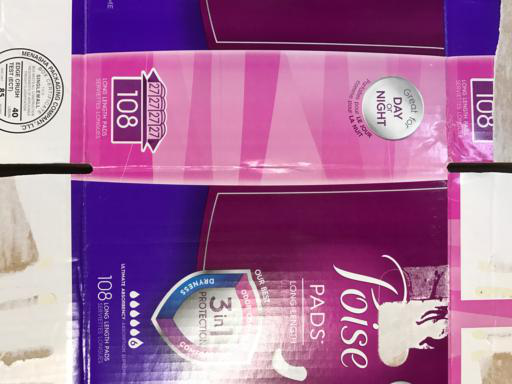

In [76]:
learn.data.test_ds[0][0]    # learn.dataset.train[0][0]

In [78]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [80]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['cardboard', 'plastic', 'cardboard', 'paper', 'paper']
['cardboard', 'plastic', 'cardboard', 'trash', 'paper']


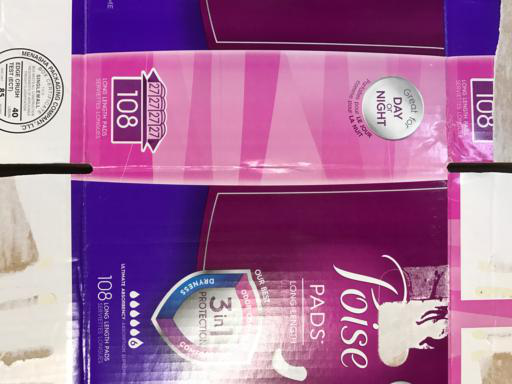

In [81]:
learn.data.test_ds[0][0]

In [82]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 95   1   1   4   0   0]
 [  1  91  18   1  14   1]
 [  1  14  83   3   1   1]
 [  0   0   1 146   2   0]
 [  0  10   6   2 100   3]
 [  3   2   2   6   3  19]]


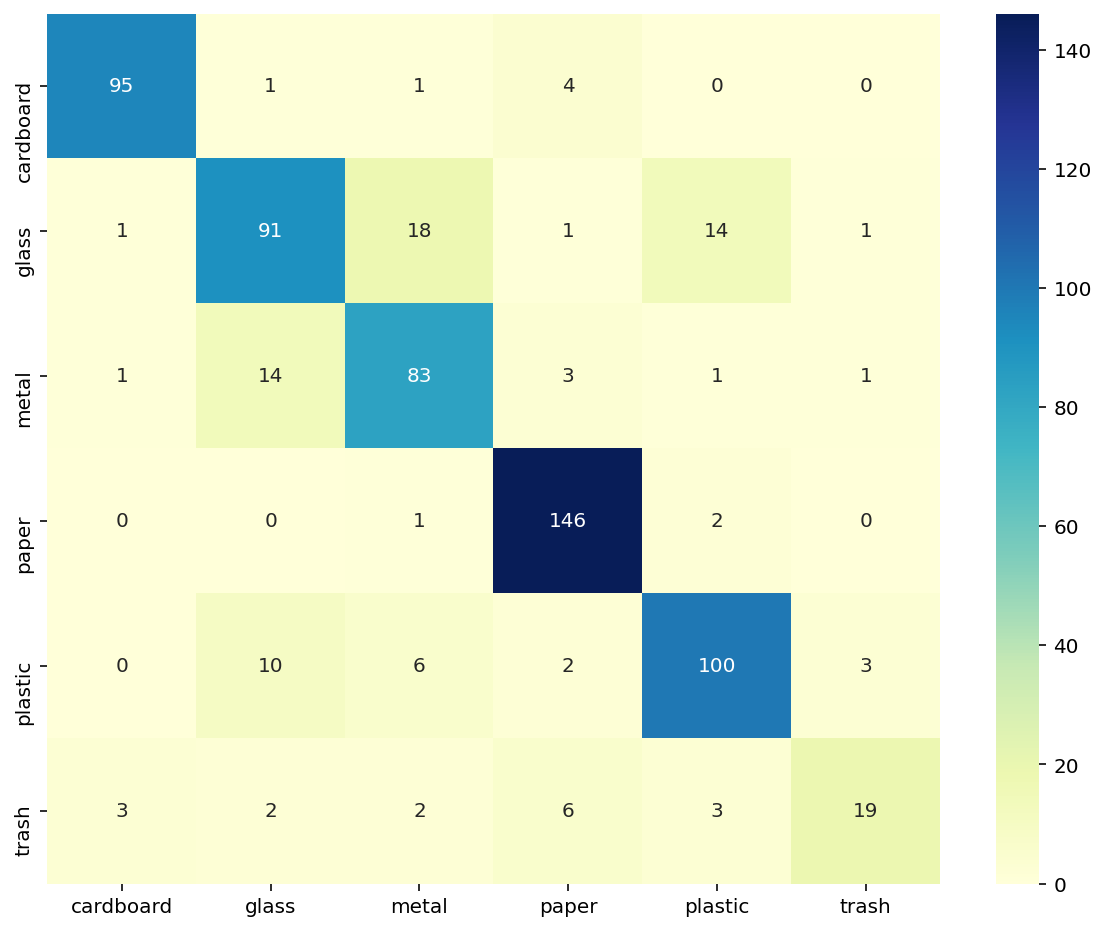

In [83]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [84]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [86]:
accuracy = correct/sum(sum(cm))
accuracy

0.8409448818897638

**Observation:** We got accuracy of 84.0% on the test data which is pretty good-- the original creators of the TrashNet dataset achieved a test accuracy of 63% with a support vector machine on a 70-30 test-train split.

**Conclusion**